In [1]:
import SimpleITK as sitk
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import matplotlib.colors as mcolors
from utils import get_seg_image_at_volume
from matplotlib import cm

In [4]:
source_dir = '/path/to/dataset/here/'

### load startpoints and image directories

In [5]:
label_filter = sitk.LabelShapeStatisticsImageFilter()
patient_results = {}
for p in os.listdir(source_dir):
    if not os.path.isdir(os.path.join(source_dir, p)) or p =='simulations':
        continue
    patientnumber = p[4:]
    patient_dir = os.path.join(source_dir, p, 'ATLAS')
    
    registered_im = sitk.ReadImage(os.path.join(patient_dir, 'BASE_TUMOR_to_ATLAS_bspline.nii.gz')) > 0
    label_filter.Execute(registered_im)
    centroid = label_filter.GetCentroid(1)
    index = registered_im.TransformPhysicalPointToIndex(centroid)
    base_vol = label_filter.GetPhysicalSize(1)
    
    registered_im_fu = sitk.ReadImage(os.path.join(patient_dir, 'FOLLOWUP_TUMOR_to_atlas_bspline.nii.gz')) > 0
    label_filter.Execute(registered_im_fu)
    fu_vol = label_filter.GetPhysicalSize(1)
    
    
    patient_results[p] = {
        'base_seg_path': os.path.join(patient_dir, 'BASE_TUMOR_to_ATLAS_bspline.nii.gz'),
        'base_seg': registered_im,
        'base_vol': base_vol,
        'followup_seg_path': os.path.join(patient_dir, 'FOLLOWUP_TUMOR_to_atlas_bspline.nii.gz'),
        'followup_seg': registered_im_fu,        
        'fu_vol': fu_vol,
        'tissue_path': os.path.join(patient_dir, 'FOLLOWUP_TISSUE_to_atlas_bspline.nii.gz'),
        'centroid': index,
        'patient_number': patientnumber
    }
    
    for modelname in ['BASE', 'TISSUE', 'DTI']:
        patient_results[p][modelname] = os.path.join(source_dir, p, modelname)
           

In [6]:
def plot_seg(background: np.array, seg: np.array, ref_seg:np.array, cut_coords: tuple, axs=None, color='g', label='', annotation=None):
    
    size = 50
    overflow_min = [min(c - size, 0) for c in cut_coords]
    overflow_max = [max(c + size -s, 0) for c, s in zip(cut_coords, seg.shape)]
    max_axes = [min(c + size - o, s) for c, s, o in zip(cut_coords, seg.shape, overflow_min)]
    min_axes = [max(c - size - o, 0) for c, o in zip(cut_coords, overflow_max)]

    if axs is None:
        fig, axs = plt.subplots(1,2, figsize=(10,5))
        axs[0].imshow(background[
            cut_coords[2],
            min_axes[1]:max_axes[1], 
            min_axes[0]:max_axes[0]], cmap='gray')
        axs[0].imshow(ref_seg[
            cut_coords[2],
            min_axes[1]:max_axes[1], 
            min_axes[0]:max_axes[0]], alpha=0.5*ref_seg[
            cut_coords[2],
            min_axes[1]:max_axes[1], 
            min_axes[0]:max_axes[0]], cmap='OrRd')
        axs[0].invert_yaxis()
        axs[1].imshow(background[
            min_axes[2]:max_axes[2],
            cut_coords[1],
            min_axes[0]:max_axes[0]], cmap='gray')
        axs[1].imshow(ref_seg[
            min_axes[2]:max_axes[2],
            cut_coords[1],
            min_axes[0]:max_axes[0]], alpha=0.5*ref_seg[
            min_axes[2]:max_axes[2],
            cut_coords[1],
            min_axes[0]:max_axes[0]], cmap='OrRd')
        axs[1].invert_yaxis()
        if annotation is not None:
    
            axs[0].annotate(annotation + ' Axial', (5, 5), color='white', fontsize='xx-large', backgroundcolor='black')
            axs[1].annotate(annotation + ' Coronal', (5, 5), color='white', fontsize='xx-large', backgroundcolor='black')
        
    axs[0].contour(seg[
            cut_coords[2],
            min_axes[1]:max_axes[1], 
            min_axes[0]:max_axes[0]], colors=color, levels=[0.5], linewidths=2)
    axs[1].contour(seg[
            min_axes[2]:max_axes[2],
            cut_coords[1],
            min_axes[0]:max_axes[0]], colors=color, levels=[0.5], linewidths=2)
    
    
    for a in axs:
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.axis('off')
        a.set_aspect('equal')

    plt.subplots_adjust(wspace=0, hspace=0)
        
    return axs

## Plot baseline 

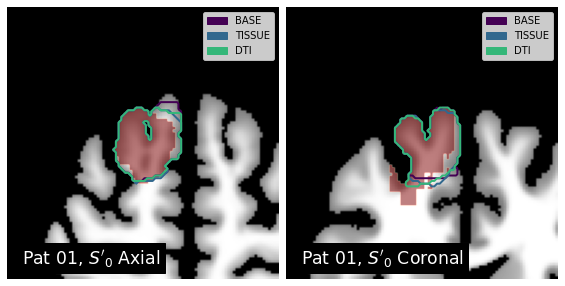

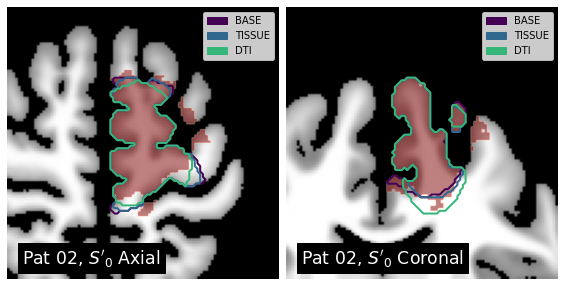

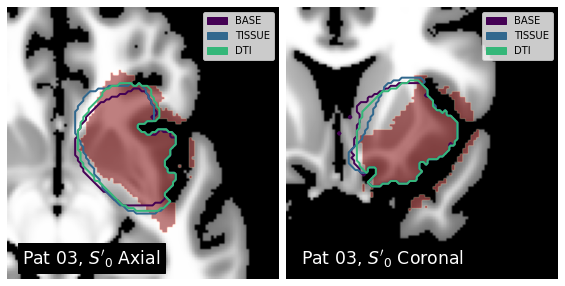

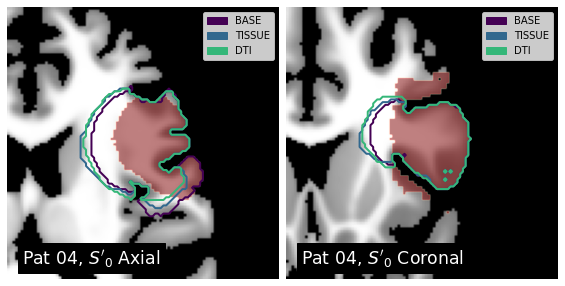

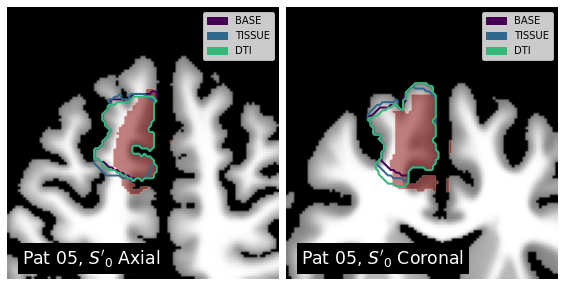

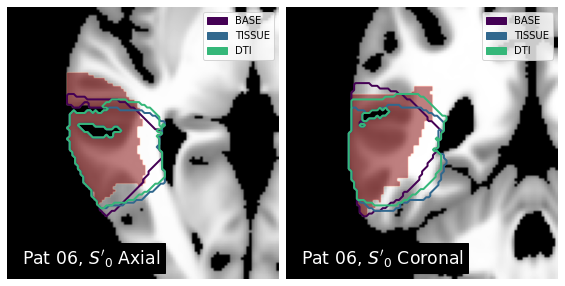

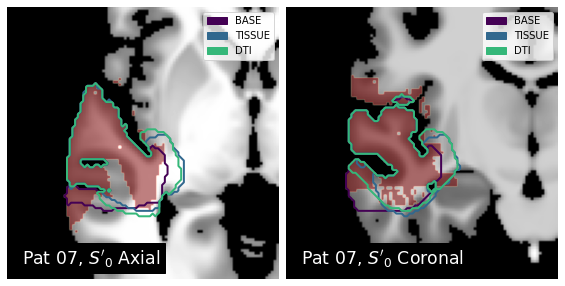

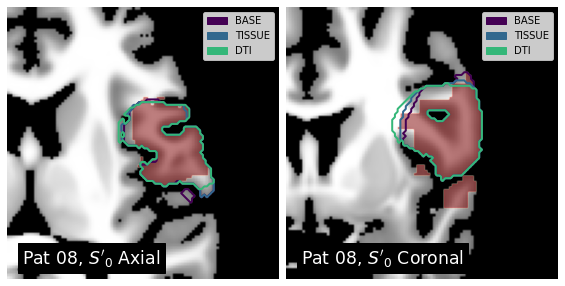

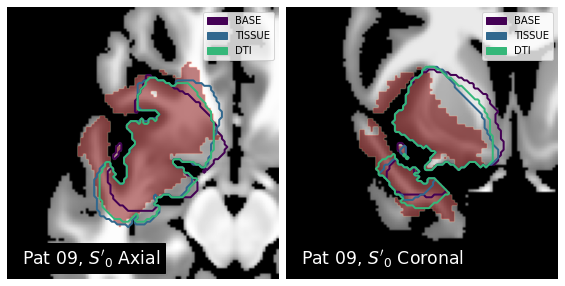

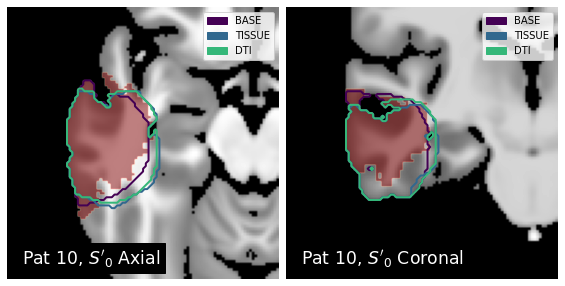

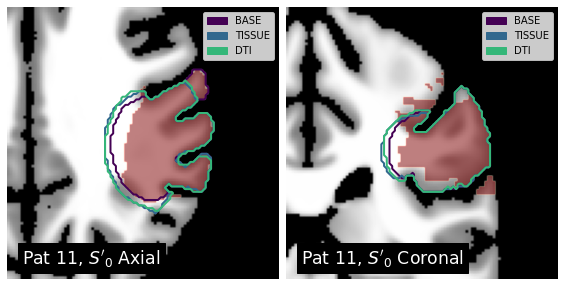

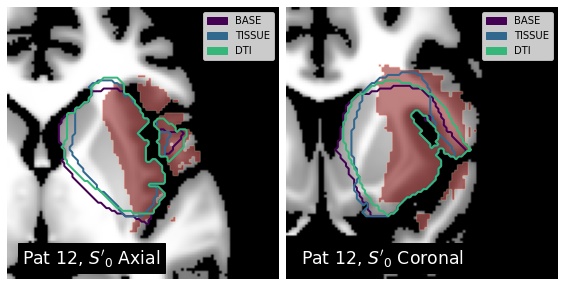

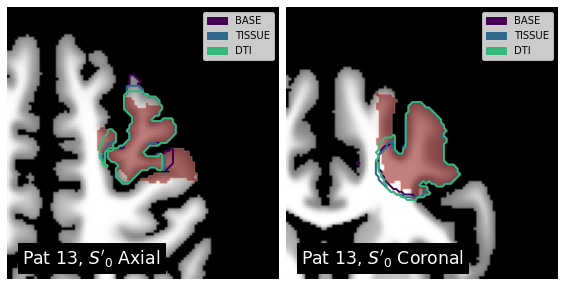

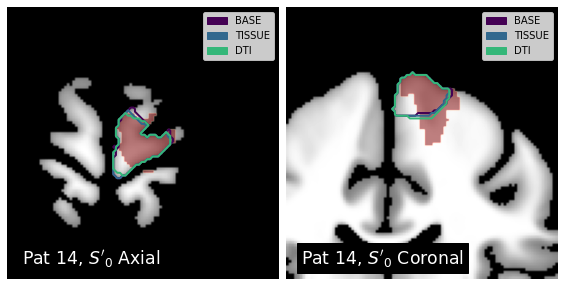

In [7]:
atlas_path = '../resources/IITmean_t1.nii.gz'
atlas_wm_path = '../resources/IIT_WM_tissue_prob.nii.gz'
atlas_gm_path = '../resources/IIT_GM_tissue_prob.nii.gz'
atlas_img = sitk.ReadImage(atlas_path)
atlas_arr = sitk.GetArrayFromImage(atlas_img)    
wm_img = sitk.ReadImage(atlas_wm_path) 
gm_img = sitk.ReadImage(atlas_gm_path)
exclusion_img = wm_img + gm_img < 0.8
exclusion_arr = sitk.GetArrayFromImage(exclusion_img)
atlas_arr[exclusion_arr > 0] = 0
for i_loc, (p, params) in enumerate(patient_results.items()):
    startpoint = (params['centroid'][0], params['centroid'][1], params['centroid'][2])
    

    
    base_seg = params['base_seg']
    base_seg_arr = sitk.GetArrayFromImage(base_seg)
    base_seg_arr[exclusion_arr > 0] = 0
    vol = np.sum(base_seg_arr)

    n = 3
    norm = mcolors.Normalize(vmin=0, vmax=n)
    colors = [cm.viridis(norm(i)) for i in range(n)]

    axs=None
    contours = []
    for i, (model, c) in enumerate(zip(['BASE', 'TISSUE', 'DTI'], colors)):
        tti_path = os.path.join(params[model], 'ranked_result.nii.gz')
        tti_img = sitk.ReadImage(tti_path)
        tti_arr = sitk.GetArrayFromImage(tti_img)

        segim = get_seg_image_at_volume(tti_img, vol)
        seg_array = sitk.GetArrayFromImage(segim)
        
        axs = plot_seg(atlas_arr, seg_array, base_seg_arr, startpoint, axs=axs, color=[c], annotation=f"Pat {params['patient_number']}, $S'_0$")

    proxy = [plt.Rectangle((0,0),1,1,color=c) for c in colors]
    axs[0].legend(proxy, list(['BASE', 'TISSUE', 'DTI']))
    axs[1].legend(proxy, list(['BASE', 'TISSUE', 'DTI']))
    plt.savefig(f'figures/model_results/base_{params["patient_number"]}.jpg', bbox_inches='tight', pad_inches=0, dpi=200)
    plt.show()
    plt.close()
    

## Plot followup

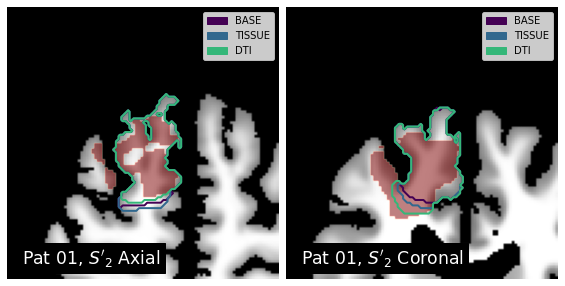

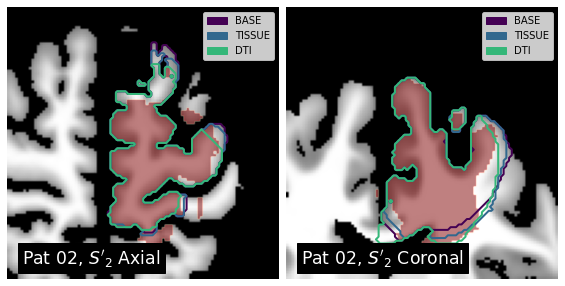

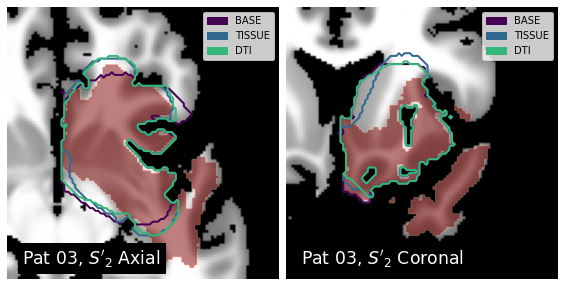

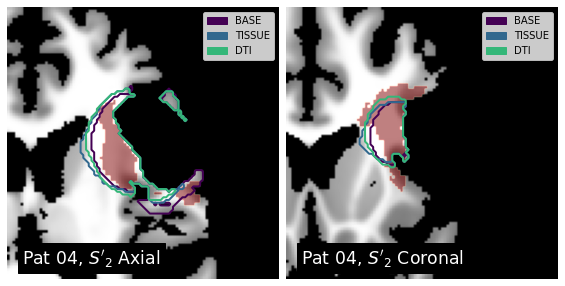

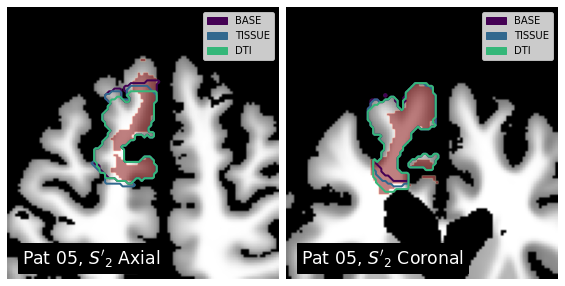

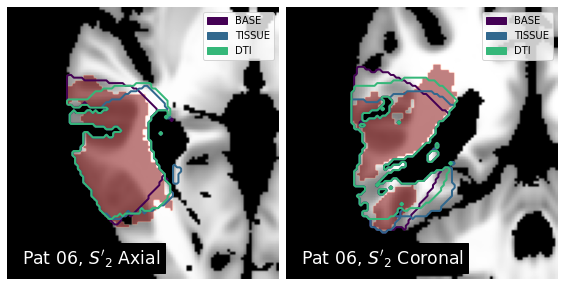

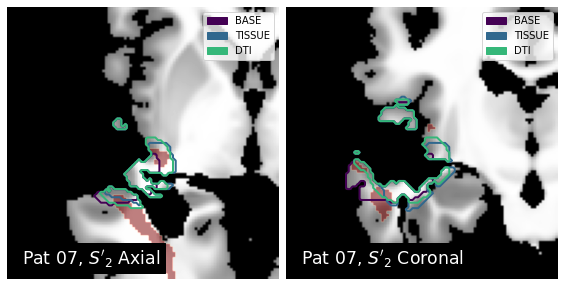

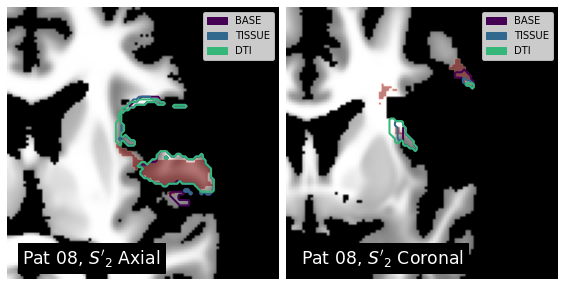

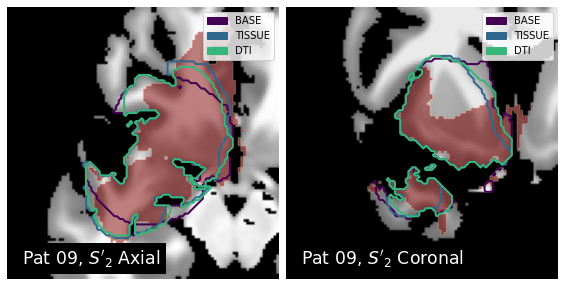

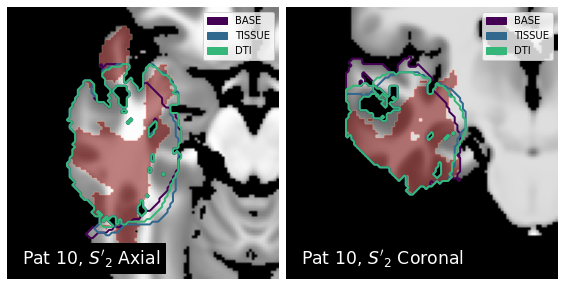

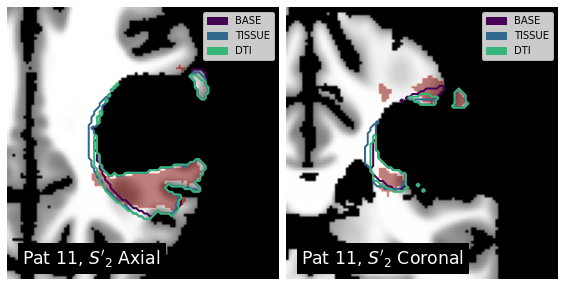

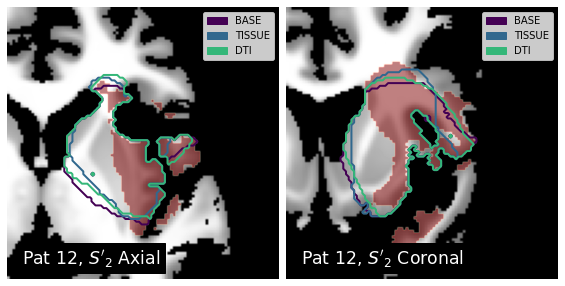

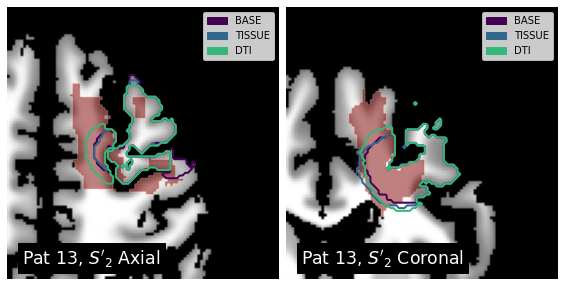

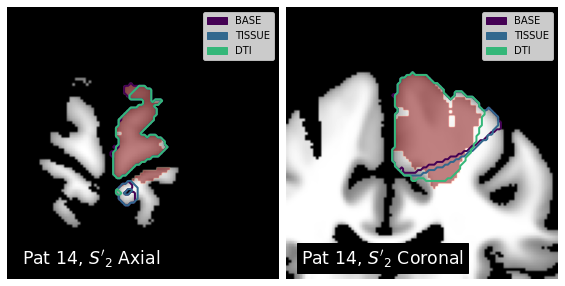

In [9]:
for i_loc, (p, params) in enumerate(patient_results.items()):
    startpoint = (params['centroid'][0], params['centroid'][1], params['centroid'][2])
    

    n = 3
    norm = mcolors.Normalize(vmin=0, vmax=n)
    colors = [cm.viridis(norm(i)) for i in range(n)]
    tissue_img = sitk.ReadImage(params['tissue_path'])
    exclusion_img_flair = (tissue_img + sitk.Cast(params['followup_seg'], tissue_img.GetPixelIDValue())) < 2
    exclusion_array_flair = sitk.GetArrayFromImage(exclusion_img_flair)
    exclusion_arr_comb = exclusion_array_flair + exclusion_arr
    ref_seg_arr = sitk.GetArrayFromImage(params['followup_seg'])
    ref_seg_arr[exclusion_arr_comb > 0] = 0
    corrected_atlas = atlas_arr.copy()
    corrected_atlas[exclusion_arr_comb > 0] = 0
    vol = np.sum(ref_seg_arr)
    axs=None
    contours = []
    for i, (model, c) in enumerate(zip(['BASE', 'TISSUE', 'DTI'], colors)):
        tti_path = os.path.join(params[model], 'ranked_result.nii.gz')
        tti_img = sitk.ReadImage(tti_path)
        tti_img = tti_img + sitk.Cast(exclusion_img_flair, tti_img.GetPixelIDValue()) * 10000.01
        segim = get_seg_image_at_volume(tti_img, vol)
        seg_array = sitk.GetArrayFromImage(segim)
        
        axs = plot_seg(corrected_atlas, seg_array, ref_seg_arr, startpoint, axs=axs, color=[c], annotation=f"Pat {params['patient_number']}, $S'_2$")
    

    proxy = [plt.Rectangle((0,0),1,1,color=c) for c in colors]
    axs[0].legend(proxy, list(['BASE', 'TISSUE', 'DTI']))
    axs[1].legend(proxy, list(['BASE', 'TISSUE', 'DTI']))
    plt.savefig(f'figures/model_results/fu_{params["patient_number"]}.jpg', bbox_inches='tight', pad_inches=0, dpi=200)
    plt.show()
    plt.close()